# **On the Hunt for Pulsar Stars**

# Introduction

**Pulsar stars** are neutron stars that produce radio emission, which when continuously and rapidly rotated, produce a detectable periodic radio emission. In astronomical research, possible pulsar stars can be identified as **‘candidates.’** Candidates are characterized by the average value of different patterns produced by their rotations. Nearly 2,000 pulsars have been discovered, however there are still many more unidentified in our galaxy (Keith et al., 2010). 


<img src="https://media.giphy.com/media/l3dj5M4YLaFww31V6/giphy.gif" width="480" />

*Source: https://media.giphy.com/media/l3dj5M4YLaFww31V6/giphy.gif*


*A High Time Resolution Universe Survey was done to collect data on pulsar star candidates using a radio telescope. 
Of 17,898 collected candidates, 1,639 were pulsar stars [positive class (1)], and 16,259 were RFI/noise (false candidates) [negative class (0)]. Pulsar stars are the minority of detections.

These stars were characterized by **8 variables** from the integrated pulse profile and *DM-SNR curve (Dispersion Measure v. Signal-to-Noise Ratio curve)*.

The Dispersion Measure of a pulsar is the quantity of electrons between an observer and the pulsar, and it can be used to indicate distance from a detected pulsar (Pulsar, n.d.). The Signal-to-Noise Ratio is the ratio of wanted signal to unwanted noise; this ratio is typically low in pulsar stars due to received signals being low (Pulsar, n.d).
The Integrated Pulse Profile is the “fingerprint” of the pulsar, which is used to distinguish pulsar stars due to their characteristic profile (Liu, n.d.). They are consistent from multiple observations (Liu, n.d.).



**The question we aim to address is:**

Given an observed candidate pulsar star’s data (integrated profile mean, integrated profile standard deviation, integrated profile excess kurtosis, integrated profile skewness, DM-SNR curve mean, DM-SNR curve standard deviation, DM-SNR curve excess kurtosis, DM-SNR curve skewness), can we successfully and accurately determine if the presented candidate is a pulsar star?

The data set we are working with is characterized by the following:
* **Data format**: CSV.
* **Multivariate** data set.
* Candidates in separate rows.
* Candidates described by **8 continuous variables**:
    - Variables 1-4: simple statistics from **pulse (folded) profile**
    - Variables 6-8: simple statistics from **DM-SNR curve**
    - Variable 9: **class variable** [0 (negative class, non-pulars) or 1 (positive class, pulsars)]


In [27]:
install.packages("themis")
library(tidyverse)
library(cowplot)
library(repr)
library(tidymodels)
library(themis)
set.seed(8) 

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



# Description of Libraries/Packages Used:

* `install.packages("themis")` and `library(themis)` was installed and used for upscaling minority class in training data before making a model.
* `library(tidyverse)` accessed the tidyverse meta package to use functions for reading and wrangling pulsar star data.
* `library(cowplot)` allowed plots to be arranged into a grid (Wilke, 2020).
* `library(repr)` created readable representations of data.
* `library(tidymodels)` was used for modelling.









# Preliminary Exploratory Data Analysis:

We first had to download the sample of pulsar stars dataset H2RU2 UCI Machine Learning Repository into the data and then read the file using `read_csv` because the delimiter present was a comma – we called the dataset `star_data`. We made our last column, `X9`, into a factor using the function `as_factor` because it was a categorical statistical variable, and we added column names using the function `colnames`.

In [28]:
star_data <- read_csv("HTRU_2.csv", col_names=FALSE, show_col_types = FALSE) |>
    mutate(X9 = as_factor(X9))

colnames(star_data) <- c("integrated_profile_mean", "integrated_profile_st_dev", 
                         "integrated_profile_excess_kurtosis","integrated_profile_skewness",
                         "dm_snr_curve_mean","dm_snr_curve_st_dev",
                         "dm_snr_curve_excess_kurtosis","dm_snr_curve_skewness",
                         "is_pulsar_star")

sample_n(star_data, 5)

integrated_profile_mean,integrated_profile_st_dev,integrated_profile_excess_kurtosis,integrated_profile_skewness,dm_snr_curve_mean,dm_snr_curve_st_dev,dm_snr_curve_excess_kurtosis,dm_snr_curve_skewness,is_pulsar_star
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
120.26562,40.97150,-0.0621932,0.7003721,4.875418,27.06243,6.423170,43.4495277,0
48.07812,32.40023,3.5966131,17.3149805,64.764214,72.62912,1.105638,0.2806927,1
101.28906,35.08676,0.4551854,2.3095122,2.858696,17.61976,8.189531,80.5372445,0
147.40625,46.14624,-0.5610487,0.5355521,2.950669,17.15384,8.361733,86.4214103,0
91.66406,38.91282,0.2377319,1.5010685,3.525920,19.23582,6.971174,56.6734882,0


_Table 1: First 5 rows of the dataset displaying candidates’ 8 variables_ 

We split the data into a training set and a testing set using `initial_split` function, with 75% of the data in the training set, which we called `star_training_data`, and 25% of the data in the testing set, which we called `star_testing_data`. We built our classifier using only the training data, and then tested the accuracy of our classifier on the testing data.

In [29]:
star_split <- initial_split(star_data, prop = 0.75, strata = is_pulsar_star)  

star_training_data <- training(star_split)   
star_testing_data <- testing(star_split)

sample_n(star_training_data, 5)

integrated_profile_mean,integrated_profile_st_dev,integrated_profile_excess_kurtosis,integrated_profile_skewness,dm_snr_curve_mean,dm_snr_curve_st_dev,dm_snr_curve_excess_kurtosis,dm_snr_curve_skewness,is_pulsar_star
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
93.46875,48.12255,0.46159507,0.6859860,1.7918060,12.09623,11.353452,182.56537,0
81.63281,38.82289,0.60677565,1.8984875,0.8963211,11.50102,15.462312,273.16024,0
87.10938,36.06055,0.73766435,2.7163270,2.5618729,19.75985,8.771769,82.96544,0
89.61719,36.51543,0.41023659,2.5995292,2.2625418,17.97103,9.206931,92.92024,0
117.78906,54.76350,0.02951264,-0.5583328,2.2056856,15.39468,9.912823,118.64161,0


_Table 2: First 5 rows of the training data_

In [30]:
sample_n(star_testing_data, 5)

integrated_profile_mean,integrated_profile_st_dev,integrated_profile_excess_kurtosis,integrated_profile_skewness,dm_snr_curve_mean,dm_snr_curve_st_dev,dm_snr_curve_excess_kurtosis,dm_snr_curve_skewness,is_pulsar_star
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
109.50781,53.17791,0.3409544,-0.2960606,2.384615,15.06311,9.6920965,119.604208,0
114.07031,45.07549,0.3725373,0.3848339,3.674749,22.45479,7.9090135,69.290189,0
103.72656,41.52648,0.2940411,0.7518841,2.852007,20.32879,7.8832463,66.391748,0
105.49219,43.50072,0.1541802,0.4081166,2.316054,19.09851,9.3772293,95.200946,0
22.96875,28.21013,6.6530311,47.9690273,127.337793,82.08953,-0.2059049,-1.154988,1


_Table 3: First 5 rows of testing data_

Using `group_by` and `summarize` functions, we could see how many pulsar stars and non-pulsar stars were in our training data, allowing us to determine if our training data was a good representation of our entire dataset.

In [31]:
star_num_table <- star_training_data |>
    group_by(is_pulsar_star) |>
    summarize(num_stars = n())
star_num_table

is_pulsar_star,num_stars
<fct>,<int>
0,12190
1,1233


_Table 4: Quantity of pulsar(1) and non-pulsar(0) stars in training set_

As we can see, the proportion in the training set is similar to the original data.

Using `group_by` and `summarize` functions we compared the mean, maximum and variance values of pulsar and non-pulsar stars for each column to see the differences between the two groups.

In [32]:
star_means_table <- star_training_data |>
    group_by(is_pulsar_star)|>
    summarize(across(integrated_profile_mean:dm_snr_curve_skewness, mean))
star_means_table

is_pulsar_star,integrated_profile_mean,integrated_profile_st_dev,integrated_profile_excess_kurtosis,integrated_profile_skewness,dm_snr_curve_mean,dm_snr_curve_st_dev,dm_snr_curve_excess_kurtosis,dm_snr_curve_skewness
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,116.38515,47.28100,0.2142841,0.3875952,8.721749,23.13491,8.885170,113.86318
1,57.29433,38.77865,3.1014584,15.3668389,49.848696,56.62647,2.752613,18.23811


_Table 5: Mean of every column in training set, grouped by non-pulsar and pulsar_

We then found the maximum across columns in the training set, grouped by non-pulsar and pulsar, using `group_by` and `summarize`.

In [33]:
star_max_table <- star_training_data |>
    group_by(is_pulsar_star)|>
    summarize(across(integrated_profile_mean:dm_snr_curve_skewness, max))
star_max_table

is_pulsar_star,integrated_profile_mean,integrated_profile_st_dev,integrated_profile_excess_kurtosis,integrated_profile_skewness,dm_snr_curve_mean,dm_snr_curve_st_dev,dm_snr_curve_excess_kurtosis,dm_snr_curve_skewness
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,192.6172,98.77891,4.529319,20.75078,223.3921,110.6422,34.53984,1191.001
1,139.2578,83.79691,8.069522,68.10162,199.5778,109.6553,30.88388,1017.383


_Table 6: Maximum across columns in training data grouped by non-pulsar and pulsar_

We then calculated the variance of every column in the data set, grouped by pulsar and non-pulsar.

In [34]:
star_var_table <- star_training_data |>
    group_by(is_pulsar_star)|>
    summarize(across(integrated_profile_mean:dm_snr_curve_skewness, var))
star_var_table

is_pulsar_star,integrated_profile_mean,integrated_profile_st_dev,integrated_profile_excess_kurtosis,integrated_profile_skewness,dm_snr_curve_mean,dm_snr_curve_st_dev,dm_snr_curve_excess_kurtosis,dm_snr_curve_skewness
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,305.5090,38.06275,0.1103549,1.025453,586.3772,270.2635,17.775787,11249.930
1,911.7591,62.68170,3.5347778,197.522253,2040.9392,392.3525,9.942395,2888.439


_Table 7: Variance across columns in training data grouped by non-pulsar and pulsar_

Using the `ggplot` and `geom_point` functions, we showed 4 scatterplots by grouping the variables with similarities: Mean of Integrated Profile vs. Mean of DM-SNR curve, Skewness of Integrated Profile vs. Skewness of DM-SNR curve, Standard deviation of Integrated Profile vs. Standard Deviation of SM-SNR curve, and Excess kurtosis of Integrated Profile vs. Excess Kurtosis of DM-SNR curve. When the plots were grouped together using `plot_grid` , we saw there was a significant distinction between pulsar stars and non-pulsar stars in each scatterplot, and so we decided to use all 8 variables in our classifier. 

Mean of Integrated Profile verses the mean of DM-SNR Curve plotted in scatterplot:

In [35]:
options(repr.plot.width = 20, repr.plot.height = 8)
plot_1<- ggplot(star_training_data, aes(x = integrated_profile_mean, y = dm_snr_curve_mean, 
                                        color = is_pulsar_star, shape = is_pulsar_star)) +
    geom_point(alpha=0.5) +
    labs(x = "Mean Value from Integrated Profile",
         y = "Mean Value from DM-SNR Curve",
         color = "Pulsar Star?") +
    ggtitle("Figure 1. Pulsar Candidate DM-SNR  vs Integrated Profile Mean") +
    scale_color_manual(name = "Is Pulsar Star?",
                       labels = c("No", "Yes"), 
                       values = c("orange2", "steelblue2"))+
    scale_shape_manual(name = "Is Pulsar Star?",
                       labels = c("No", "Yes"), 
                       values = c(19, 17))+
    theme(text = element_text(size = 15))

Skewness of Integrated Profile verses skewness of DM-SNR Curve plotted in scatterplot:

In [36]:
plot_2 <- ggplot(star_training_data, aes(x = integrated_profile_skewness, y = dm_snr_curve_skewness,
                         color = is_pulsar_star, shape = is_pulsar_star)) +
    geom_point(alpha=0.3) +
    labs(x = "Integrated Profile Skewness",
         y = "DM-SNR curve Skewness",
         color = "Pulsar Star?") +
    ggtitle("Figure 2. Integrated Profile Skewness vs DM-SNR Curve Skewness") +
    scale_color_manual(name = "Is Pulsar Star?",
                       labels = c("No", "Yes"), 
                       values = c("orange2", "steelblue2"))+
    scale_shape_manual(name = "Is Pulsar Star?",
                       labels = c("No", "Yes"), 
                       values = c(19, 17))+
    theme(text = element_text(size = 15))


Standard deviation of Integrated Profile verses Standard Deviation of SM-SNR Curve plotted in scatterplot:

In [37]:
plot_3 <- ggplot(star_training_data, aes(x = integrated_profile_st_dev, y = dm_snr_curve_st_dev,
                         color = is_pulsar_star, shape = is_pulsar_star)) +
    geom_point(alpha=0.3) +
    labs(x = "Integrated Profile Standard Deviation",
         y = "DM-SNR curve Standard Deviation",
         color = "Pulsar Star?") +
    ggtitle("Figure 3. DM-SNR curve Standard Deviation vs Integrated Profile Standard Deviation") +
    scale_color_manual(name = "Is Pulsar Star?",
                       labels = c("No", "Yes"), 
                       values = c("orange2", "steelblue2"))+
    scale_shape_manual(name = "Is Pulsar Star?",
                       labels = c("No", "Yes"), 
                       values = c(19, 17))+
    theme(text = element_text(size = 15))


Excess kurtosis of Integrated Profile verses excess kurtosis of DM-SNR curve plotted in scatterplot:

In [38]:
plot_4 <- ggplot(star_training_data, aes(x = integrated_profile_excess_kurtosis, y = dm_snr_curve_excess_kurtosis,
                         color = is_pulsar_star, shape = is_pulsar_star)) +
    geom_point(alpha=0.3) +
    labs(x = "Integrated Profile Excess Kurtosis",
         y = "DM-SNR curve Excess Kurtosis") +
    ggtitle("Figure 4. DM-SNR curve Excess Kurtosis vs Integrated Profile Excess Kurtosis") +
    scale_color_manual(name = "Is Pulsar Star?",
                       labels = c("No", "Yes"), 
                       values = c("orange2", "steelblue2"))+
    scale_shape_manual(name = "Is Pulsar Star?",
                       labels = c("No", "Yes"), 
                       values = c(19, 17))+
    theme(text = element_text(size = 15))

Putting plots together so they can be compared easily.

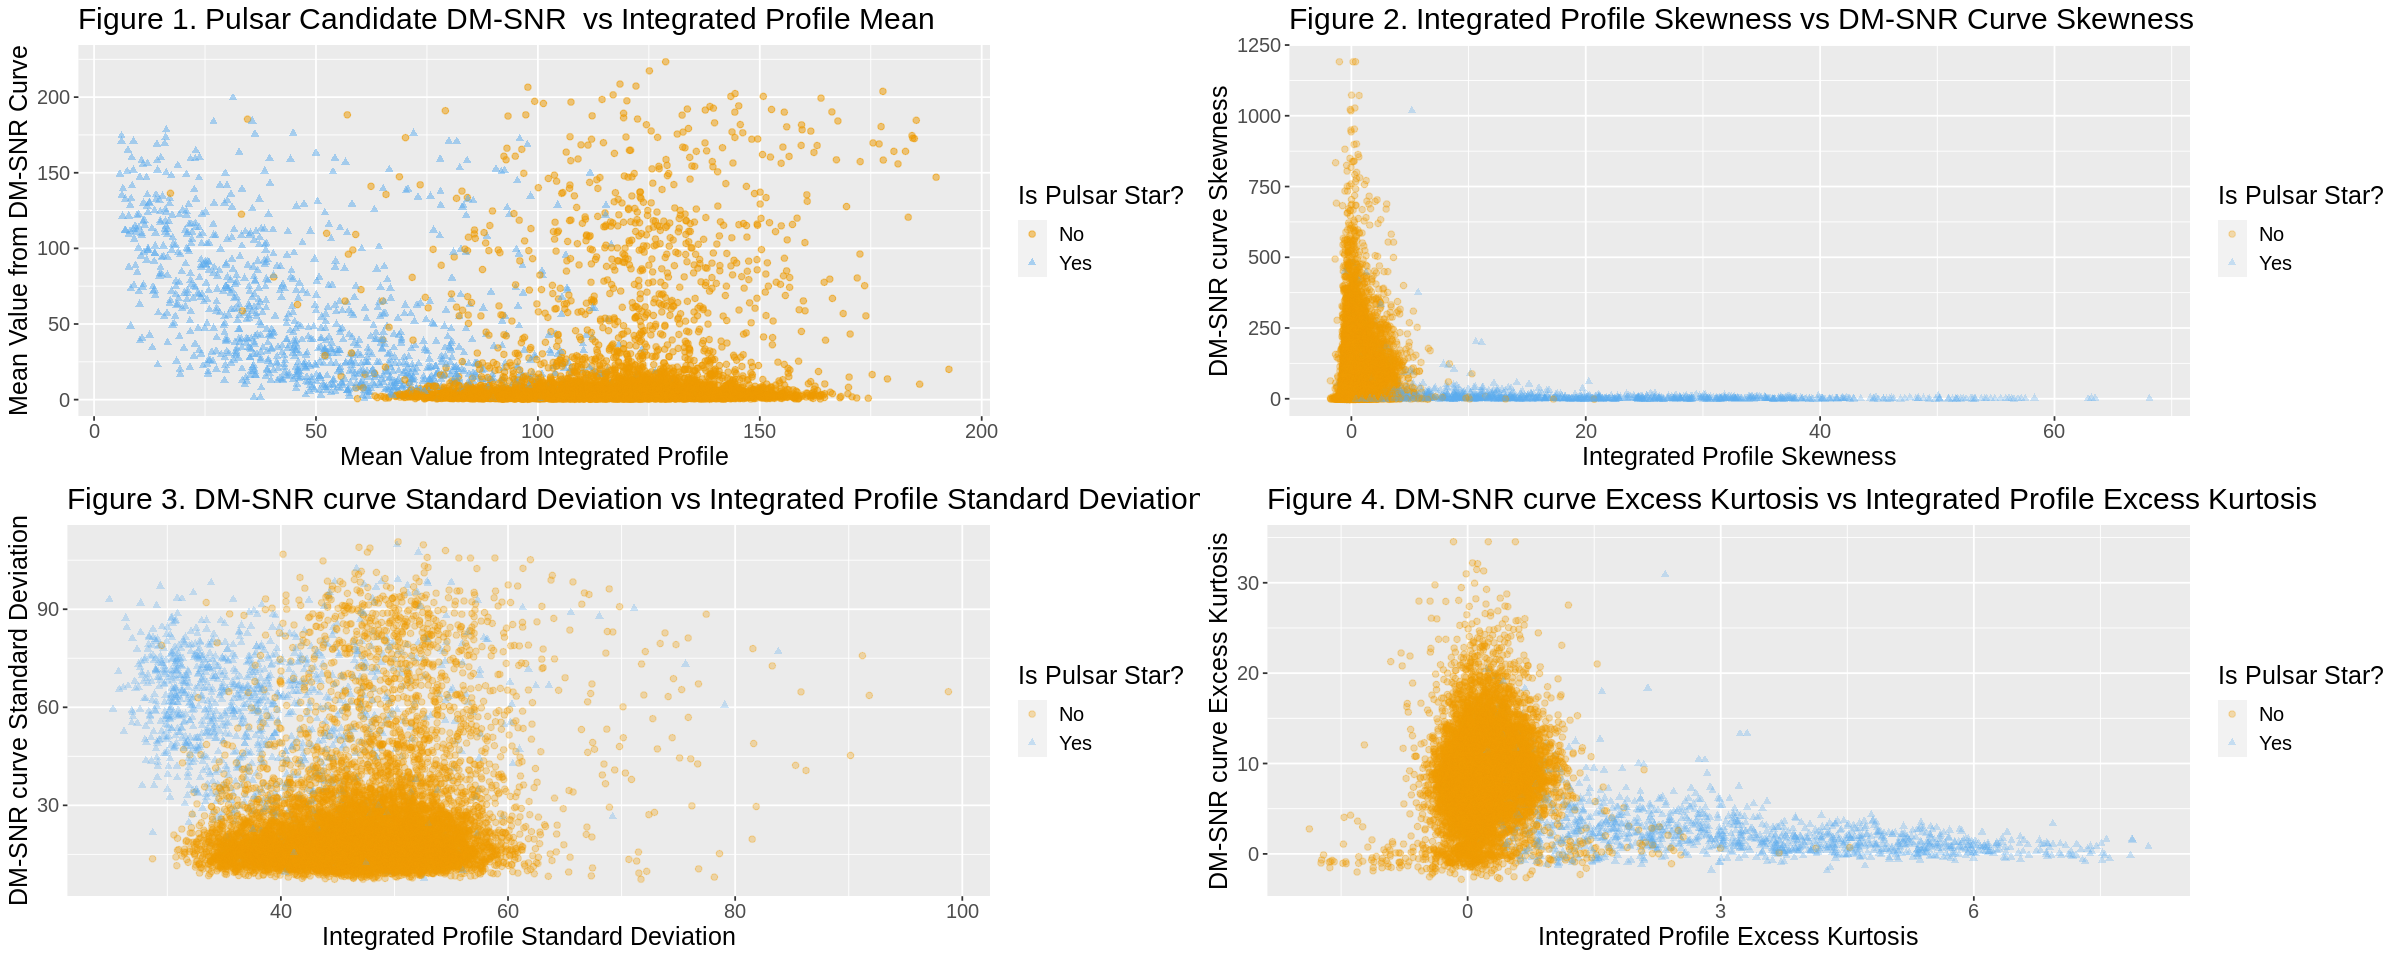

In [39]:
plot_grid(plot_1,plot_2,plot_3,plot_4)

In Figure 1, we saw that a larger number of pulsar star observations fell in the lower right-hand section of the plot area while non-pulsar stars were more spread out in the left-hand area; we concluded pulsar stars had a greater mean value for the integrated profile than non-pulsar stars. In Figure 2, we saw that pulsar stars typically fell in the left-hand section and occupied a greater height than the non-pulsar stars which were quite spread out length-wise in the right-hand section of the plot area; we concluded pulsar stars had a smaller integrated profile skewness and a larger skewness in the DM-SNR curve than non-pulsar stars. In Figure 3, a majority of the pulsar star observations were in the bottom of the plot area while the non-pulsar stars were in the upper-left hand side of the plot area; we concluded that pulsar stars had overall a larger standard deviation in the integrated profile and smaller standard deviation in the DM-SNR curve than non-pulsar stars. In Figure 4, a majority of the pulsar star observations were in the left-hand section and reached a greater height compared to non-pulsar stars which were spread out in the right-hand side of the plot area; we concluded that pulsar stars have smaller excess kurtosis in the integrated profile and greater excess kurtosis in the DM-SNR curve that non-pulsar stars.

We standardise the data using the `mutate` and `scale` function so each variable had an equal contribution when building the classifier. Scaling our variables was especially important for our training data as variables, such as the integrated profile mean, were much larger than variables, such as the integrated profile excess kurtosis. 

In [40]:
star_data_standardized <- star_training_data |>
    mutate(integrated_profile_mean = scale(integrated_profile_mean, center = TRUE),
           integrated_profile_st_dev = scale(integrated_profile_st_dev, center = TRUE),
           integrated_profile_excess_kurtosis = scale(integrated_profile_excess_kurtosis, center = TRUE),
           integrated_profile_skewness = scale(integrated_profile_skewness, center = TRUE),
           dm_snr_curve_mean = scale(dm_snr_curve_mean, center = TRUE),
           dm_snr_curve_st_dev = scale (dm_snr_curve_st_dev, center = TRUE),
           dm_snr_curve_excess_kurtosis = scale(dm_snr_curve_excess_kurtosis, center = TRUE),
           dm_snr_curve_skewness = scale(dm_snr_curve_skewness, center = TRUE))

sample_n(star_data_standardized, 5)

integrated_profile_mean,integrated_profile_st_dev,integrated_profile_excess_kurtosis,integrated_profile_skewness,dm_snr_curve_mean,dm_snr_curve_st_dev,dm_snr_curve_excess_kurtosis,dm_snr_curve_skewness,is_pulsar_star
"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>",<fct>
0.32894418,0.1405930,-0.2980119,-0.2623934,-0.3771817,-0.6321936,0.7277727,0.44075359,0
0.73910174,0.6668857,-0.4878147,-0.3263280,-0.2169507,0.3439620,-0.6312650,-0.71397775,0
-0.25371813,1.0513355,-0.3855221,-0.3704596,1.0250318,2.0054206,-1.6517883,-1.00143062,0
0.05122377,0.2787145,-0.3617685,-0.3130165,-0.3532454,-0.4358053,0.2868211,-0.03279814,0
0.99663543,-0.2362175,-0.2882542,-0.2034518,-0.3305344,-0.5217921,0.1977802,0.04945468,0


_Table 8: The first 5 rows of the standardized training data_

We used the `group_by` and `summarize` functions to show the mean values for pulsar and non-pulsar stars for each variable. We could better compare the characteristics of pulsar and non-pulsar stars when the data was standardized.

In [41]:
star_means_table_standardized <- star_data_standardized |>
    group_by(is_pulsar_star)|>
    summarize(across(integrated_profile_mean:dm_snr_curve_skewness, mean))
star_means_table_standardized

is_pulsar_star,integrated_profile_mean,integrated_profile_st_dev,integrated_profile_excess_kurtosis,integrated_profile_skewness,dm_snr_curve_mean,dm_snr_curve_st_dev,dm_snr_curve_excess_kurtosis,dm_snr_curve_skewness
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,0.2125032,0.1147163,-0.2505877,-0.2238561,-0.1287507,-0.1588611,0.125359,0.08283543
1,-2.1009033,-1.1341377,2.4774246,2.2131431,1.2728880,1.5705728,-1.239356,-0.81894882


_Table 9: Calculated mean of every column in standardized training set, grouped by non-pulsar and pulsar_

We then calculated the maximum of every column in standardised training set, grouped by non-pulsar and pulsar with `group_by` and `summarize`.

In [42]:
star_max_table_standardized <- star_data_standardized |>
    group_by(is_pulsar_star)|>
    summarize(across(integrated_profile_mean:dm_snr_curve_skewness, max))
star_max_table_standardized

is_pulsar_star,integrated_profile_mean,integrated_profile_st_dev,integrated_profile_excess_kurtosis,integrated_profile_skewness,dm_snr_curve_mean,dm_snr_curve_st_dev,dm_snr_curve_excess_kurtosis,dm_snr_curve_skewness
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,3.196989,7.678904,3.826572,3.089067,7.187385,4.359833,5.834447,10.240692
1,1.107968,5.478297,7.171613,10.792657,6.375772,4.308873,5.020864,8.603405


_Table 10: Maximum of standardised training set across columns, grouped by non-pulsar and pulsar_

Finally, we calculated variance of every column in standardised training set, grouped by non-pulsar and pulsar with `group_by` and `summarize`..

In [43]:
star_means_table_standardized <- star_data_standardized |>
    group_by(is_pulsar_star)|>
    summarize(across(integrated_profile_mean:dm_snr_curve_skewness, var))
star_means_table_standardized

is_pulsar_star,integrated_profile_mean,integrated_profile_st_dev,integrated_profile_excess_kurtosis,integrated_profile_skewness,dm_snr_curve_mean,dm_snr_curve_st_dev,dm_snr_curve_excess_kurtosis,dm_snr_curve_skewness
<fct>,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>"
0,0.4682608,0.8211936,0.09852314,0.0271423,0.6810772,0.7206504,0.8802973,1.0004872
1,1.3974747,1.3523410,3.15579484,5.2281378,2.3705510,1.0461977,0.4923700,0.2568768


_Table 11: Variance of standardised training set across columns, grouped by non-pulsar and pulsar_

# Methods

Classification can be used to successfully determine whether data from a candidate pulsar star is indeed indicative of a true pulsar star. We chose classification, as the pulsar star data provided 2 classes, 0 and 1, indicating a pulsar star, or a false candidate. This fits in with the definition of a classification model; “predicting a categorical class (sometimes called a label) for an observation given its other variables (sometimes called features)” (Timbers, 2022).
In our project, the categorical class is “negative”(0) for false candidates, and “positive”(1) for true candidates – pulsar stars. The variables in our project include (8 variables). 

We will be using all the variables/columns because in Robert James Lyon's thesis, the features of the integrated profile and the DM-SNR curve are all crucial in determining pulsar stars from candidates (Lyon, 2016). We will conduct our data analysis using a standardized training and testing data set, perform cross validation, and pick the best K value by creating a Accuracy Estimate vs. Neighbors plot. We will visualize our data using a confusion matrix plot to allow us to determine the training data's accuracy in predicting pulsar candidates from the test data.

We notice the training set was not balanced as there were more non-pulsar stars than pulsar stars; if left without balancing, our classifier would be skewered to more likely predict non-pulsar stars. We balanced the training set by oversampling pulsar star data – we added the `step_upsample` to our recipe, and we applied the `prep` and `bake` functions to apply the recipe to the training data.

In [44]:
star_ups_recipe <- recipe(is_pulsar_star~., data = star_training_data)|>
    step_upsample(is_pulsar_star, over_ratio = 1, skip = FALSE)|>
    prep()

star_training_data <- bake(star_ups_recipe, star_training_data)

star_training_data |>
  group_by(is_pulsar_star) |>
  summarize(n = n())

is_pulsar_star,n
<fct>,<int>
0,12190
1,12190


_Table 12: Number of pulsar and non-pulsar stars after balancing the training data_

We make the recipe and center and scale the recipe, using `step_scale` and `step_center` respectively, for tuning to the best K value. The K value is the number of neighbouring observations that our classifier considers when making a prediction, and so we tuned the model to find the optimal K value.

In [45]:
star_recipe <- recipe(is_pulsar_star ~., data = star_training_data)|>
    step_scale(all_predictors())|>
    step_center(all_predictors())

To find the most desired K value, we used cross-validation, using the function `vfold_cv` to take the average of several classifiers made from V-folds of the training data. Using cross-validation decreases the influence of a unlucky data being selected for the validation set, as compared to if the data was only split once. Although splitting the data into more folds will be more accurate, we chose 5 folds as our computers were unable to handle greater folds. It has also been seen having more than 5 folds may only have an insignificant effect on the accuracy. We specified the model, inputting `neighbors = tune()` to evaluate the accuracies from a range of different K values. In `gridvals`, we specified the parameter for K to go from 1 to 100 by 5. In our `workflow`, we used `tune_grid` function to fit the model in each value in our range of K values.

In [46]:
star_vfold <- vfold_cv(star_training_data, v = 5, strat = is_pulsar_star)

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune())|>
    set_engine("kknn")|>
    set_mode("classification")

gridvals = tibble(neighbors = seq(from = 1, to = 100, by = 5))

knn_results <- workflow() |>
  add_recipe(star_recipe) |>
  add_model(knn_tune) |>
  tune_grid(resamples = star_vfold, grid = gridvals) |>
  collect_metrics() |>
  filter(.metric == "accuracy")

Using `knn_results` we plotted estimated accuracies against k-values using the `ggplot` function, and used `geom_line` to find the optimal K value.

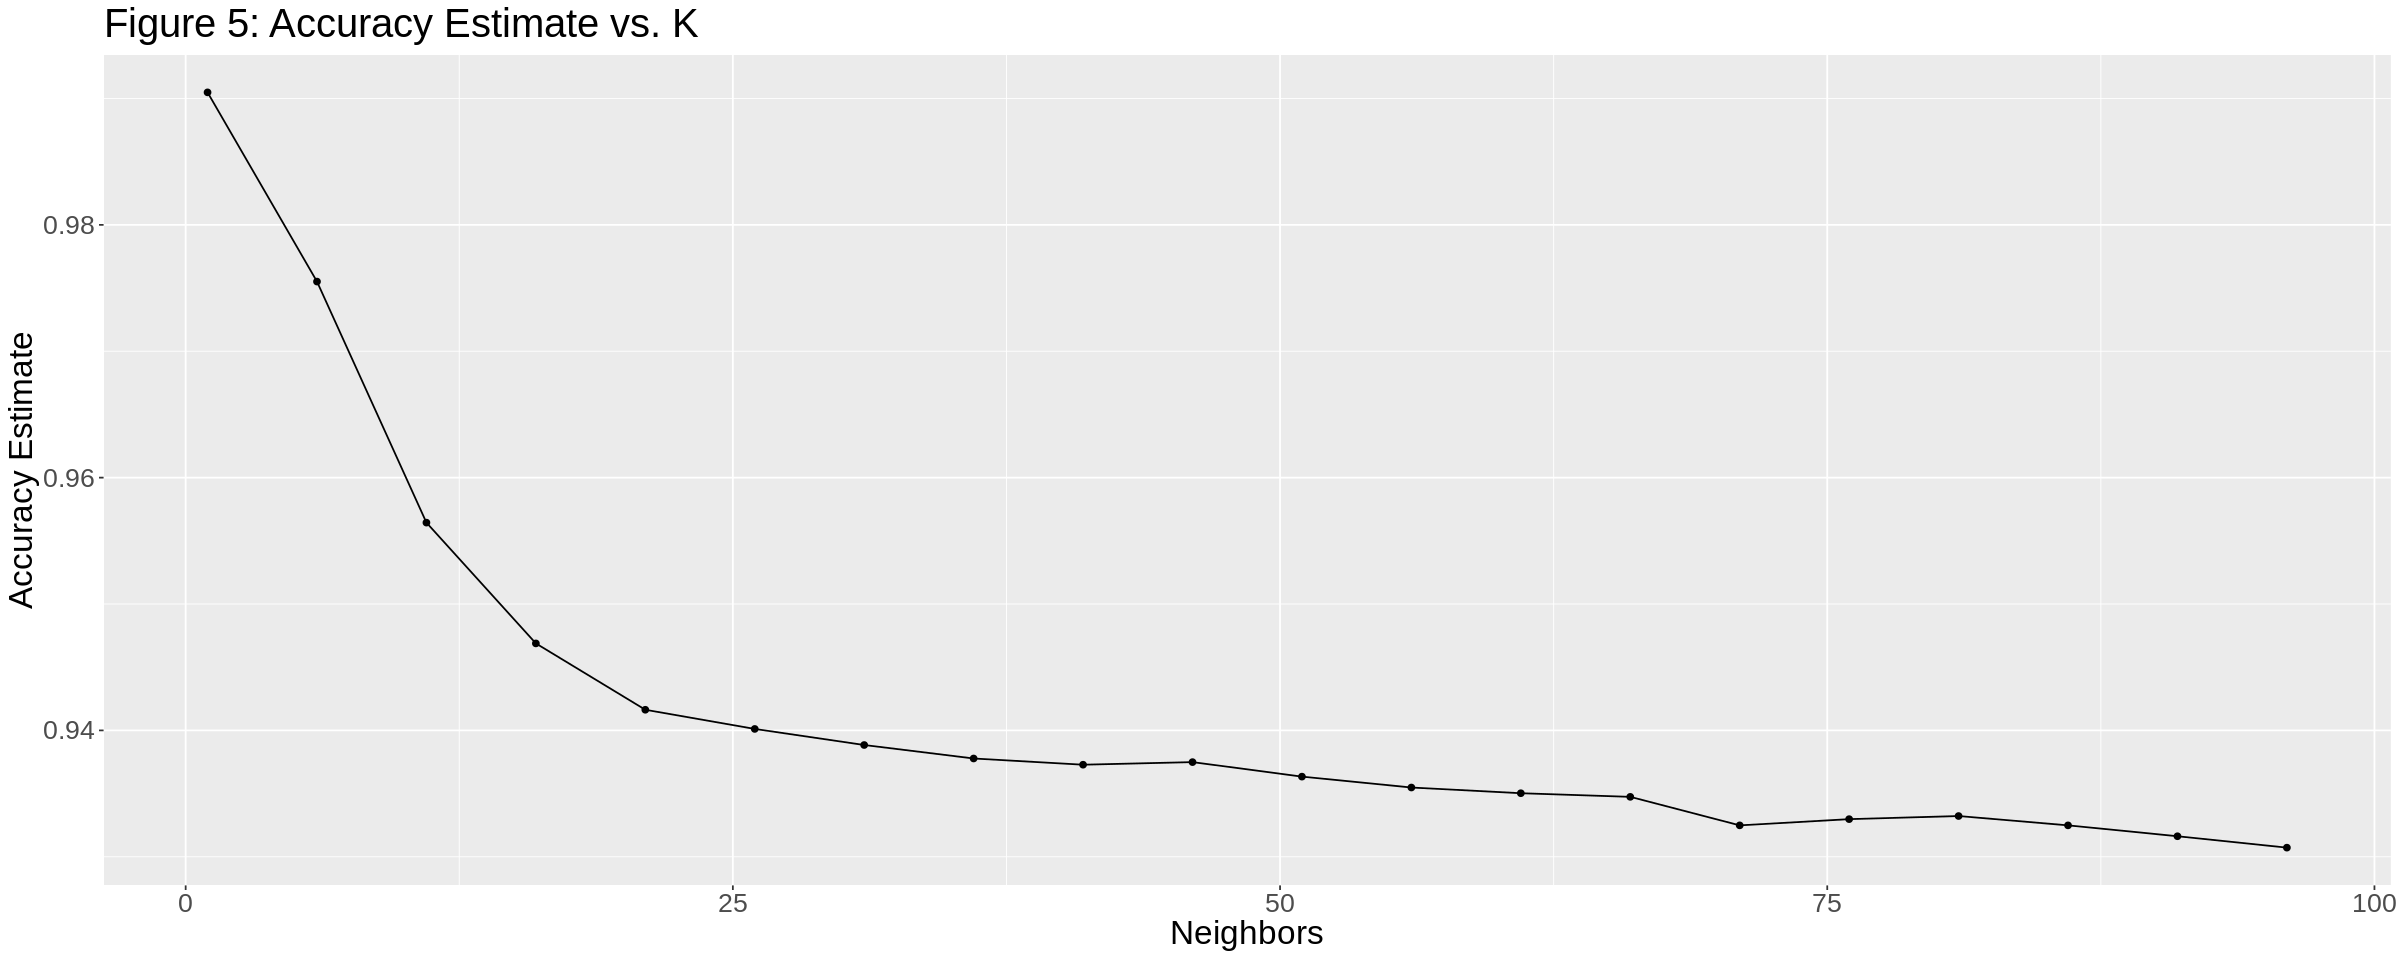

In [47]:
cross_val_plot <- knn_results |> 
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") +
    ggtitle("Figure 5: Accuracy Estimate vs. K") +
    theme(text = element_text(size = 20))
cross_val_plot

We see that a number close to zero has the highest accuracy, and as K values increase, the accuracy decreases. If K was equal to 1, there would be overfitting, and picking K to be 2 would result in our classifier not having a tie-breaker; thus, K equal to 3 was the most suitable. 

Using our K value of 3, we made a new model specification and retrained the model using the `fit()` function. 

In [48]:
best_k <- 3

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k)|>
    set_engine("kknn")|>
    set_mode("classification")

knn_fit <- workflow()|>
    add_recipe(star_recipe)|>
    add_model(knn_spec)|>
    fit(data = star_training_data)


We used `predict()` function to have our classifier make predictions for our test set. We evaluated the accuracy of our classification model using the `metrics()` function. The accuracy of the model was 97%, which is greater than the 91% that the majority classifier would have produced. We also used `conf_mat()` to create a confusion matrix.

In [49]:
star_predictions <- predict(knn_fit, star_testing_data)|>
    bind_cols(star_testing_data)

accuracy <- star_predictions |> 
    metrics(truth = is_pulsar_star, estimate = .pred_class) |> 
    select(.metric, .estimate) |> 
    head(1)
accuracy

star_confusion_matrix <- star_predictions |> 
    conf_mat(truth = is_pulsar_star, estimate = .pred_class)

.metric,.estimate
<chr>,<dbl>
accuracy,0.9660335


_Table 13: Accuracy of final classification model_

As the accuracy seemed suspiciously high, we decided to create a confusion matrix plot to visualize the proportion of correct predictions for predicted pulsar stars versus non-pulsar. We first started with `as.data.frame` and `factor` to prepare the numbers for the plot (QuantizerQuantizer, 2020). 

Note: We did try creating a colored prediction map visualization, but that was not possible due to the number of variables we have

In [50]:
predictions <- star_predictions|> 
    select(.pred_class, is_pulsar_star)

for_show1 <- as.data.frame(table(predictions$.pred_class, predictions$is_pulsar_star))
for_show1$Var1 <- factor(for_show1$Var1, rev(levels(for_show1$Var2)))
fill1 <- tibble(fill = as_factor(seq(from=1,to=4,by=1)))

for_show1  <- bind_cols(for_show1,fill1)

We created a tile plot describing the confusion matrix plot using `ggplot` and `geom_tile` (QuantizerQuantizer, 2020).

In [51]:
options(repr.plot.width = 12, repr.plot.height = 10)
update_geom_defaults("text", list(size = 10))

conf_mat_vis1<- for_show1|>
  ggplot(aes(x=Var2,y=Var1, fill = fill)) +
  geom_tile() +
  geom_text(aes(label = Freq)) +
  scale_fill_manual(values = c("#fd8d3c","#bdd7e7","#ffffd4","#2171b5"),
                   labels = c("Non-pulsar/Non-pulsar", "Pulsar/Non-pulsar", 
                              "Non-pulsar/Pulsar", "Pulsar/Pulsar")) +
  labs(x = "Is a pulsar star?", y = "Predicted pulsar star?", title = "Figure 6. Confusion matrix",
       fill = "Prediction/True identity") +
  theme(plot.title = element_text(size = 18, hjust = 0.5, 
                                  margin = margin(20, 0, 20, 0)),
        legend.title = element_text(size = 16, margin = margin(0, 20, 10, 0)),
        axis.title.x = element_text(margin = margin(20, 20, 20, 20), size = 18),
        axis.title.y = element_text(margin = margin(0, 20, 0, 10), size = 18),
        text = element_text(size = 16))
    

We made a data frame with percent accuracies for pulsar and non-pulsar predictions using `as.data.frame` and `factor` (QuantizerQuantizer, 2020).

In [52]:
for_show2 <- as.data.frame(table(predictions$.pred_class, predictions$is_pulsar_star)/
                       rowSums(table(predictions$.pred_class, predictions$is_pulsar_star)))
for_show2$Var1 <- factor(for_show2$Var1, rev(levels(for_show2$Var2)))
fill <- tibble(fill = as_factor(seq(from=1,to=4,by=1)))

for_show2  <- bind_cols(for_show2,fill)

We used `ggplot` and `geom_tile` to create plot of percent accuracies for pulsar and non-pulsar predictions (QuantizerQuantizer, 2020).

In [53]:
options(repr.plot.width = 12, repr.plot.height = 10)

conf_mat_vis2 <- for_show2|>
  ggplot(aes(x=Var2,y=Var1, fill = fill)) +
  geom_tile() +
  geom_text(aes(label = scales::percent(Freq))) +
  scale_fill_manual(values = c("#fd8d3c","#bdd7e7","#ffffd4","#2171b5"),
                   labels = c("Non-pulsar/Non-pulsar", "Pulsar/Non-pulsar", 
                              "Non-pulsar/Pulsar", "Pulsar/Pulsar")) +
  labs(x = "Is a pulsar star?", y = "Predicted pulsar star?", title = "Figure 7. Prediction Accuracy by star type",
       fill = "Prediction/True identity") +
  theme(plot.title = element_text(size = 18, hjust = 0.5, 
                                  margin = margin(20, 0, 20, 0)),
        legend.title = element_text(size = 16, margin = margin(0, 20, 10, 0)),
        axis.title.x = element_text(margin = margin(20, 20, 20, 20), size = 18),
        axis.title.y = element_text(margin = margin(0, 20, 0, 10), size = 18),
        text = element_text(size = 16))


We used `plot_grid` to combine the confusion matrix visualization with visualization of percent accuracies by pulsar/non-pulsar star prediction.

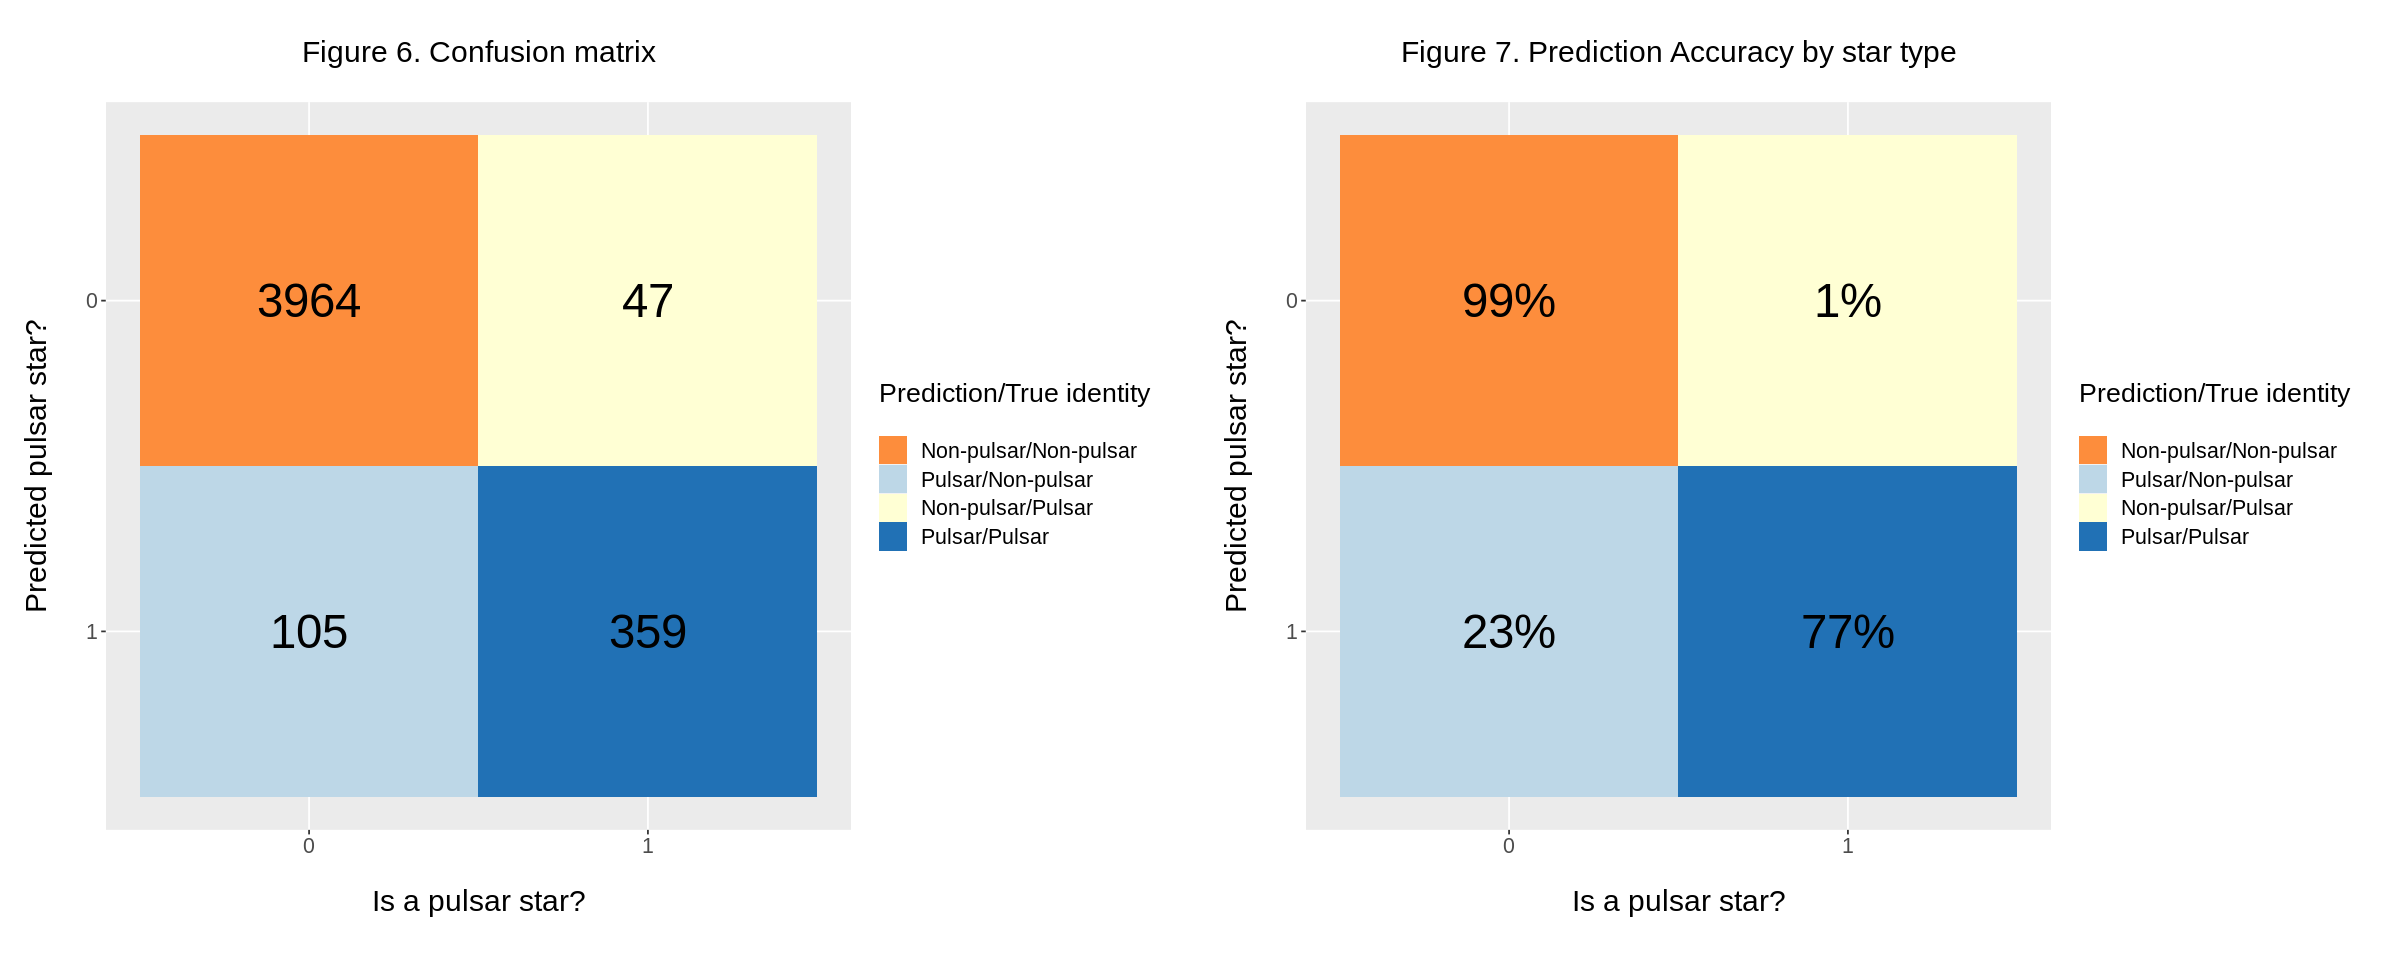

In [54]:
options(repr.plot.width = 20, repr.plot.height = 8)
plot_grid(conf_mat_vis1,conf_mat_vis2)

# Discussion

**What we found**:

From the confusion matrix plot, we found that 105 non-pulsar were incorrectly identified as pulsar stars, and 47 pulsar stars were incorrectly predicted non-pulsar stars. Overall, we found that our classification model trained by the H2RU2 data on pulsar star candidates is indeed successfully able to answer the question of  “Given an observed candidate pulsar star’s data, can we successfully and accurately determine if the presented candidate is a pulsar star?” because the accuracy was evaluated at 97%. However, it is notable that our predictions are less accurate when we predict an observation as a pulsar star (77% of predicted pulsars were true pulsars while 99% of predicted non-pulsars were non-pulsars). We think this difference is from the presence of more non-pulsar stars than pulsar stars. Since many observations are non-pulsars, any given observation is more likely to not be a pulsar. This accuracy can and should be improved to more accurately determine pulsar stars. Although the effects of a mis-classification does not present irreparable consequences, a more accurate model should be developed for determining pulsar stars, because mis-labelling a non-pulsar as a pulsar star or vice-versa may offset the work of researchers who use highly accurate mathematical calculations in their research. 99% accuracy in determining non-pulsar stars on the other hand, is quite significant and helpful in the field of astronomical research, as successfully determining non-pulsar stars still rules out the possibility of pulsar stars, providing meaningful information to researchers about possible candidates.

**Was this what we expected to find?**:

We did expect to find this level of accuracy based on our prior research. Use of all 8 variables was expected to train a good classification model as these 8 variables define and distinguish pulsar stars.


**Possible Significance of Findings**:

These findings could aid in exploration of the interstellar medium. Only ~2,000 pulsar stars have been discovered (Skelly, 2017), therefore any additional discoveries would be of significant impact in the field of astronomy. Further discoveries of pulsar stars could lead to analysis of their sizes and masses, providing researchers with the necessary data to understand pulsar star behaviours and interactions which are not presently well understood due to extreme pressure and density conditions (Skelly, 2017). 


**Future questions this could lead to:**

    - How old are the pulsar stars found?
    - How can precise measurements of the pulsar stars sizes and masses be determined?
    - Are there areas of the galaxy where more pular stars are found?


### Sources

Keith, M. J., Jameson, A., van Straten, W., Bailes, M., Johnston, S., Kramer, M., Possenti, A., Bates, S. D., Bhat, N. D. R., Burgay, M., Burke-Spolaor, S., D'Amico, N., Levin, L., McMahon, P. L., Milia, S., Stappers, B. W. (2010). The High Time Resolution Universe Pulsar Survey – I. System configuration and initial discoveries. _Monthly Notices of the Royal Astronomical Society, 409(2)_, 619–627. https://doi.org/10.1111/j.1365-2966.2010.17325.x

Liu, K. (n.d.). Introduction to Pulsar, Pulsar Timing, and measuring of Pulse Time-of-Arrivals. _West Virginia University_. Retrieved April 13, 2023, from http://ipta.phys.wvu.edu/files/student-week-2017/IPTA2017_KuoLiu_pulsartiming.pdf

Lyon, R. J.(2016). Why are Pulsars Hard to Find [Doctoral Dissertation, University of Manchester]. https://www.escholar.manchester.ac.uk/api/datastream?publicationPid=uk-ac-man-scw:305203&datastreamId=FULL-TEXT.PDF

Pulsar Dispersion Measure (n.d.). _COSMOS_. Retrieved April 13, 2023, from https://astronomy.swin.edu.au/cosmos/p/pulsar+dispersion+measure#:~:text=In%20pulsar%20astronomy%20a%20handy,an%20 observer%20and%20a%20 pulsar%E2%80%9D.

QuantizerQuantizer, & Allan Cameron. (2020). Plot a confusion matrix in R showing percentages (ggplot). _Stack Overflow_. Retrieved April 13, 2023, from https://stackoverflow.com/questions/65253809/plot-a-confusion-matrix-in-r-showing-percentages-ggplot

Skelly, C. (2017). NASA Continues to Study Pulsars, 50 Years After Their Chance Discovery. _NASA_. https://www.nasa.gov/feature/goddard/2017/nasa-continues-to-study-pulsars-50-years-after-their-chance-discovery


Timbers, Tiffany. (2022). Chapter 6 Classification II: evaluation & tuning. Data science. Retrieved April 13, 2023, from https://datasciencebook.ca/classification2.html 

Wilke, C. O. (2020). Introduction to cowplot. Retrieved April 13, 2023, from https://cran.r-project.org/web/packages/cowplot/vignettes/introduction.html 
